# Script to read and process netCDF data

## Import libraries

In [21]:
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
from shapely.geometry import mapping
import geopandas as gpd
import xarray as xr
import h5netcdf
import netCDF4
import rioxarray
import dask
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Import shapefile and netCDF data

In [3]:
# Enable Dask's automatic parallelization
dask.config.set(scheduler='threads')

<Axes: >

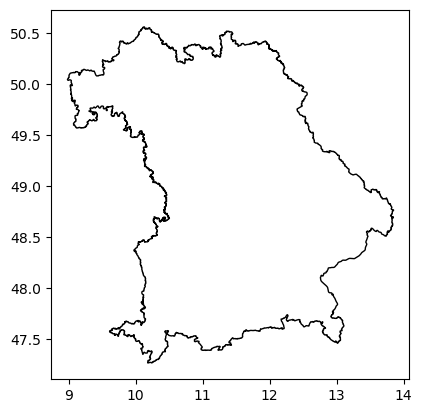

In [4]:
# Load the shapefile
shapefile_path = r"C:\Users\ge58som\study_project\bavaria_outline.shp"
bavaria_polygon = gpd.read_file(shapefile_path)
bavaria_polygon = bavaria_polygon.to_crs('EPSG:4326')

# check the shapefile
bavaria_polygon.plot(color='white', edgecolor='black')

In [5]:
# Open the netCDF file

data = xr.open_dataset('soil_average.nc').chunk({'variable': 10, 'lat': 1000, 'lon': 1000})

In [6]:
data['soil_avg']

<xarray.DataArray 'soil_avg' (variable: 10, lat: 13920, lon: 39000)> Size: 43GB
dask.array<xarray-soil_avg, shape=(10, 13920, 39000), dtype=float64, chunksize=(10, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 111kB -56.0 -55.99 -55.98 -55.97 ... 59.98 59.99 60.0
  * lon      (lon) float64 312kB -145.0 -145.0 -145.0 ... 180.0 180.0 180.0
Dimensions without coordinates: variable
Attributes:
    COLOR_TABLE_RULE_RGB_0:   0.000000e+00 2.232000e+02 255 255 0 0 255 0
    COLOR_TABLE_RULE_RGB_1:   2.232000e+02 4.464000e+02 0 255 0 0 255 255
    COLOR_TABLE_RULE_RGB_2:   4.464000e+02 6.696000e+02 0 255 255 0 0 255
    COLOR_TABLE_RULE_RGB_3:   6.696000e+02 8.928000e+02 0 0 255 255 0 255
    COLOR_TABLE_RULE_RGB_4:   8.928000e+02 1.116000e+03 255 0 255 255 0 0
    COLOR_TABLE_RULES_COUNT:  5
    Generated_with:           GRASS GIS 7.0.0beta1
    grid_mapping:             crs
    long_name:                soil_average
    units:                    [g/kg], pH * 10, [%], [%], [%], [%], [cmol/kg],...

## Clip the netCDF data

In [7]:
# Convert the dataset to use rioxarray for geospatial operations, setting the CRS
data_rio = data.rio.write_crs("EPSG:4326")

In [8]:
# Crop the data using the region of interest, applying the shapefile's geometry
clipped_data = data_rio.rio.clip(bavaria_polygon.geometry.apply(mapping), bavaria_polygon.crs, drop=True)

In [9]:
clipped_data

<xarray.Dataset> Size: 19MB
Dimensions:   (lat: 396, lon: 584, variable: 10)
Coordinates:
  * lat       (lat) float64 3kB 47.27 47.28 47.29 47.3 ... 50.55 50.55 50.56
  * lon       (lon) float64 5kB 8.979 8.988 8.996 9.004 ... 13.82 13.83 13.84
    crs       int32 4B 0
Dimensions without coordinates: variable
Data variables:
    soil_avg  (variable, lat, lon) float64 19MB dask.array<chunksize=(10, 396, 523), meta=np.ndarray>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 1.10.0, released 2013/04/24
    units:               [g/kg], pH * 10, [%], [%], [%], [%], [cmol/kg], [kg ...
    Source:              SoilGrids1km & ISRIC, Hengl et al. (2014)
    Dataset:             Soil upstream average
    Author:              sami.domisch@yale.edu
    scale_factor:        1
    Software:            GRASS 7 using the add-ons r.stream.watersheds & r.st...

## Plot the data

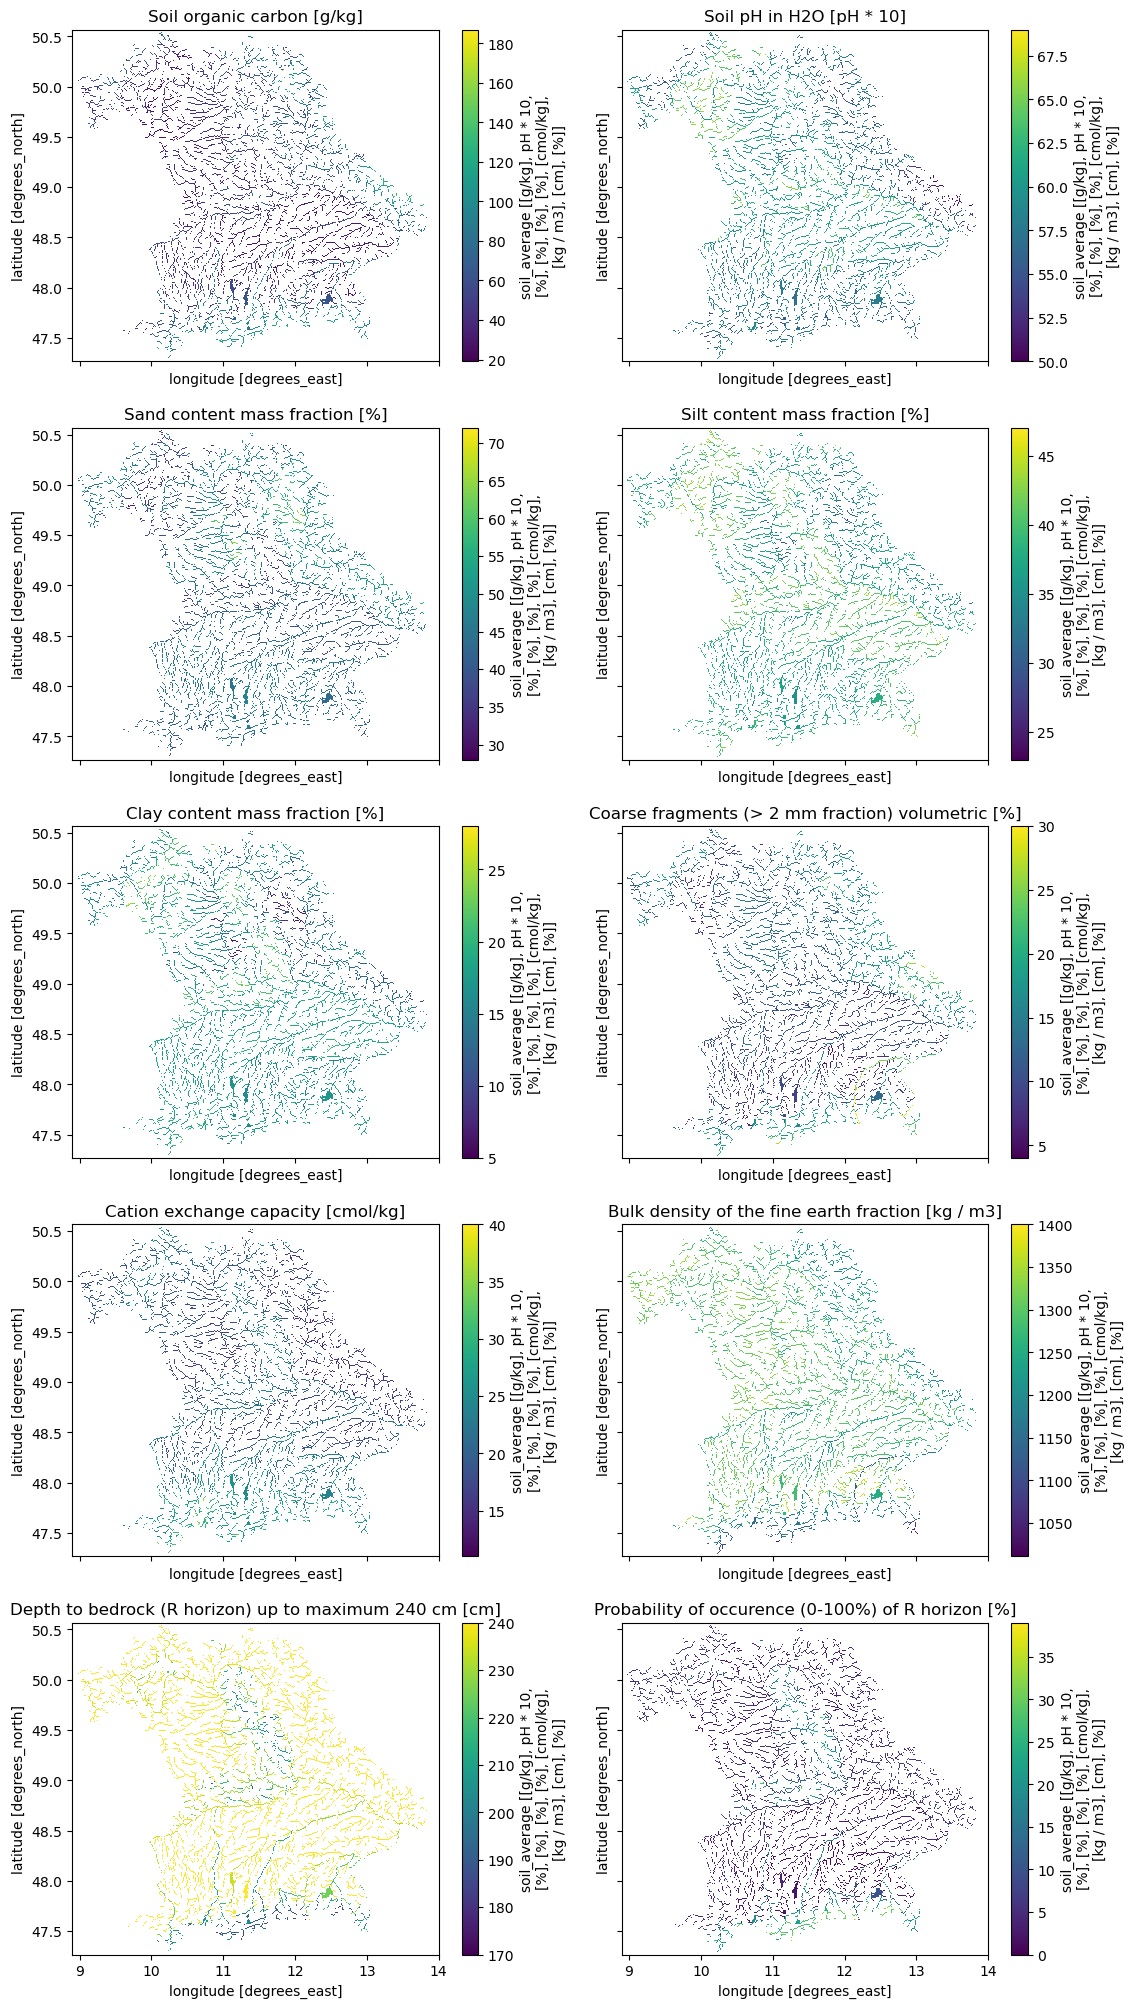

In [10]:
# quick visualization

bands_dict = {0:'Soil organic carbon [g/kg]', 1:'Soil pH in H2O [pH * 10]', 2:'Sand content mass fraction [%]', 3:'Silt content mass fraction [%]', 4:'Clay content mass fraction [%]', 5:'Coarse fragments (> 2 mm fraction) volumetric [%]', 6:'Cation exchange capacity [cmol/kg]', 7:'Bulk density of the fine earth fraction [kg / m3]', 8:'Depth to bedrock (R horizon) up to maximum 240 cm [cm]', 9:'Probability of occurence (0-100%) of R horizon [%]'}

# Create a 5*2 subplot grid
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(13, 25), sharex=True, sharey=True)

# Flatten the 2D array of subplots for easier iteration
axes = axes.flatten()

for i in range(10):

    clipped_data['soil_avg'][i].plot(ax=axes[i])
    axes[i].set_title(bands_dict[i])
    axes[i].set_xlim(8.9,14)    
    

## Convert xarray to dataframes

In [11]:
# Flatten the data to check the dimensions required for the dataframe

flat_data = clipped_data['soil_avg'].stack(space=['lat', 'lon'])
flat_data

<xarray.DataArray 'soil_avg' (variable: 10, space: 231264)> Size: 19MB
dask.array<reshape, shape=(10, 231264), dtype=float64, chunksize=(10, 115632), chunktype=numpy.ndarray>
Coordinates:
    crs      int32 4B 0
  * space    (space) object 2MB MultiIndex
  * lat      (space) float64 2MB 47.27 47.27 47.27 47.27 ... 50.56 50.56 50.56
  * lon      (space) float64 2MB 8.979 8.988 8.996 9.004 ... 13.82 13.83 13.84
Dimensions without coordinates: variable
Attributes:
    COLOR_TABLE_RULE_RGB_0:   0.000000e+00 2.232000e+02 255 255 0 0 255 0
    COLOR_TABLE_RULE_RGB_1:   2.232000e+02 4.464000e+02 0 255 0 0 255 255
    COLOR_TABLE_RULE_RGB_2:   4.464000e+02 6.696000e+02 0 255 255 0 0 255
    COLOR_TABLE_RULE_RGB_3:   6.696000e+02 8.928000e+02 0 0 255 255 0 255
    COLOR_TABLE_RULE_RGB_4:   8.928000e+02 1.116000e+03 255 0 255 255 0 0
    COLOR_TABLE_RULES_COUNT:  5
    Generated_with:           GRASS GIS 7.0.0beta1
    grid_mapping:             crs
    long_name:                soil_average
    units:                    [g/kg], pH * 10, [%], [%], [%], [%], [cmol/kg],...

In [12]:
# Prepare the dataframes

# Extract variable
lc_avg = clipped_data['soil_avg']

# Convert the DataArray to a pandas DataFrame
df = lc_avg.to_dataframe(name='value').reset_index()
display(df)


#pd.options.display.max_rows = 1000
#pd.options.display.min_rows = 500

# Pivot the DataFrame to have bands as columns
df_pivoted = df.pivot(index=['lat', 'lon'], columns='variable', values='value').reset_index()
display(df_pivoted)

#remove nan values
df_filtered = df_pivoted.dropna(axis=0, how='any').reset_index()

display(df_filtered)


,variable,lat,lon,crs,value
0,0,47.270833,8.979167,0,NaN
1,0,47.270833,8.987500,0,NaN
2,0,47.270833,8.995833,0,NaN
3,0,47.270833,9.004167,0,NaN
4,0,47.270833,9.012500,0,NaN
...,...,...,...,...,...
2312635,9,50.562500,13.804167,0,NaN
2312636,9,50.562500,13.812500,0,NaN
2312637,9,50.562500,13.820833,0,NaN
2312638,9,50.562500,13.829167,0,NaN


variable,lat,lon,0,1,2,3,4,5,6,7,8,9
0,47.270833,8.979167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,47.270833,8.987500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,47.270833,8.995833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,47.270833,9.004167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,47.270833,9.012500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
231259,50.562500,13.804167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231260,50.562500,13.812500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231261,50.562500,13.820833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231262,50.562500,13.829167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


variable,index,lat,lon,0,1,2,3,4,5,6,7,8,9
0,1902,47.295833,10.229167,98.0,59.0,39.0,40.0,21.0,19.0,32.0,1089.0,221.0,16.0
1,2487,47.304167,10.237500,97.0,59.0,39.0,40.0,21.0,18.0,32.0,1093.0,220.0,17.0
2,2488,47.304167,10.245833,100.0,59.0,39.0,40.0,21.0,19.0,32.0,1094.0,218.0,17.0
3,3073,47.312500,10.254167,98.0,59.0,39.0,40.0,21.0,19.0,32.0,1097.0,217.0,18.0
4,3074,47.312500,10.262500,99.0,59.0,40.0,40.0,20.0,20.0,31.0,1087.0,213.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16445,228480,50.529167,10.112500,84.0,58.0,36.0,43.0,21.0,14.0,26.0,1205.0,240.0,6.0
16446,228481,50.529167,10.120833,81.0,58.0,36.0,43.0,21.0,14.0,26.0,1206.0,240.0,6.0
16447,228482,50.529167,10.129167,78.0,59.0,36.0,43.0,21.0,13.0,27.0,1210.0,240.0,6.0
16448,228484,50.529167,10.145833,75.0,58.0,38.0,43.0,20.0,14.0,25.0,1234.0,237.0,7.0


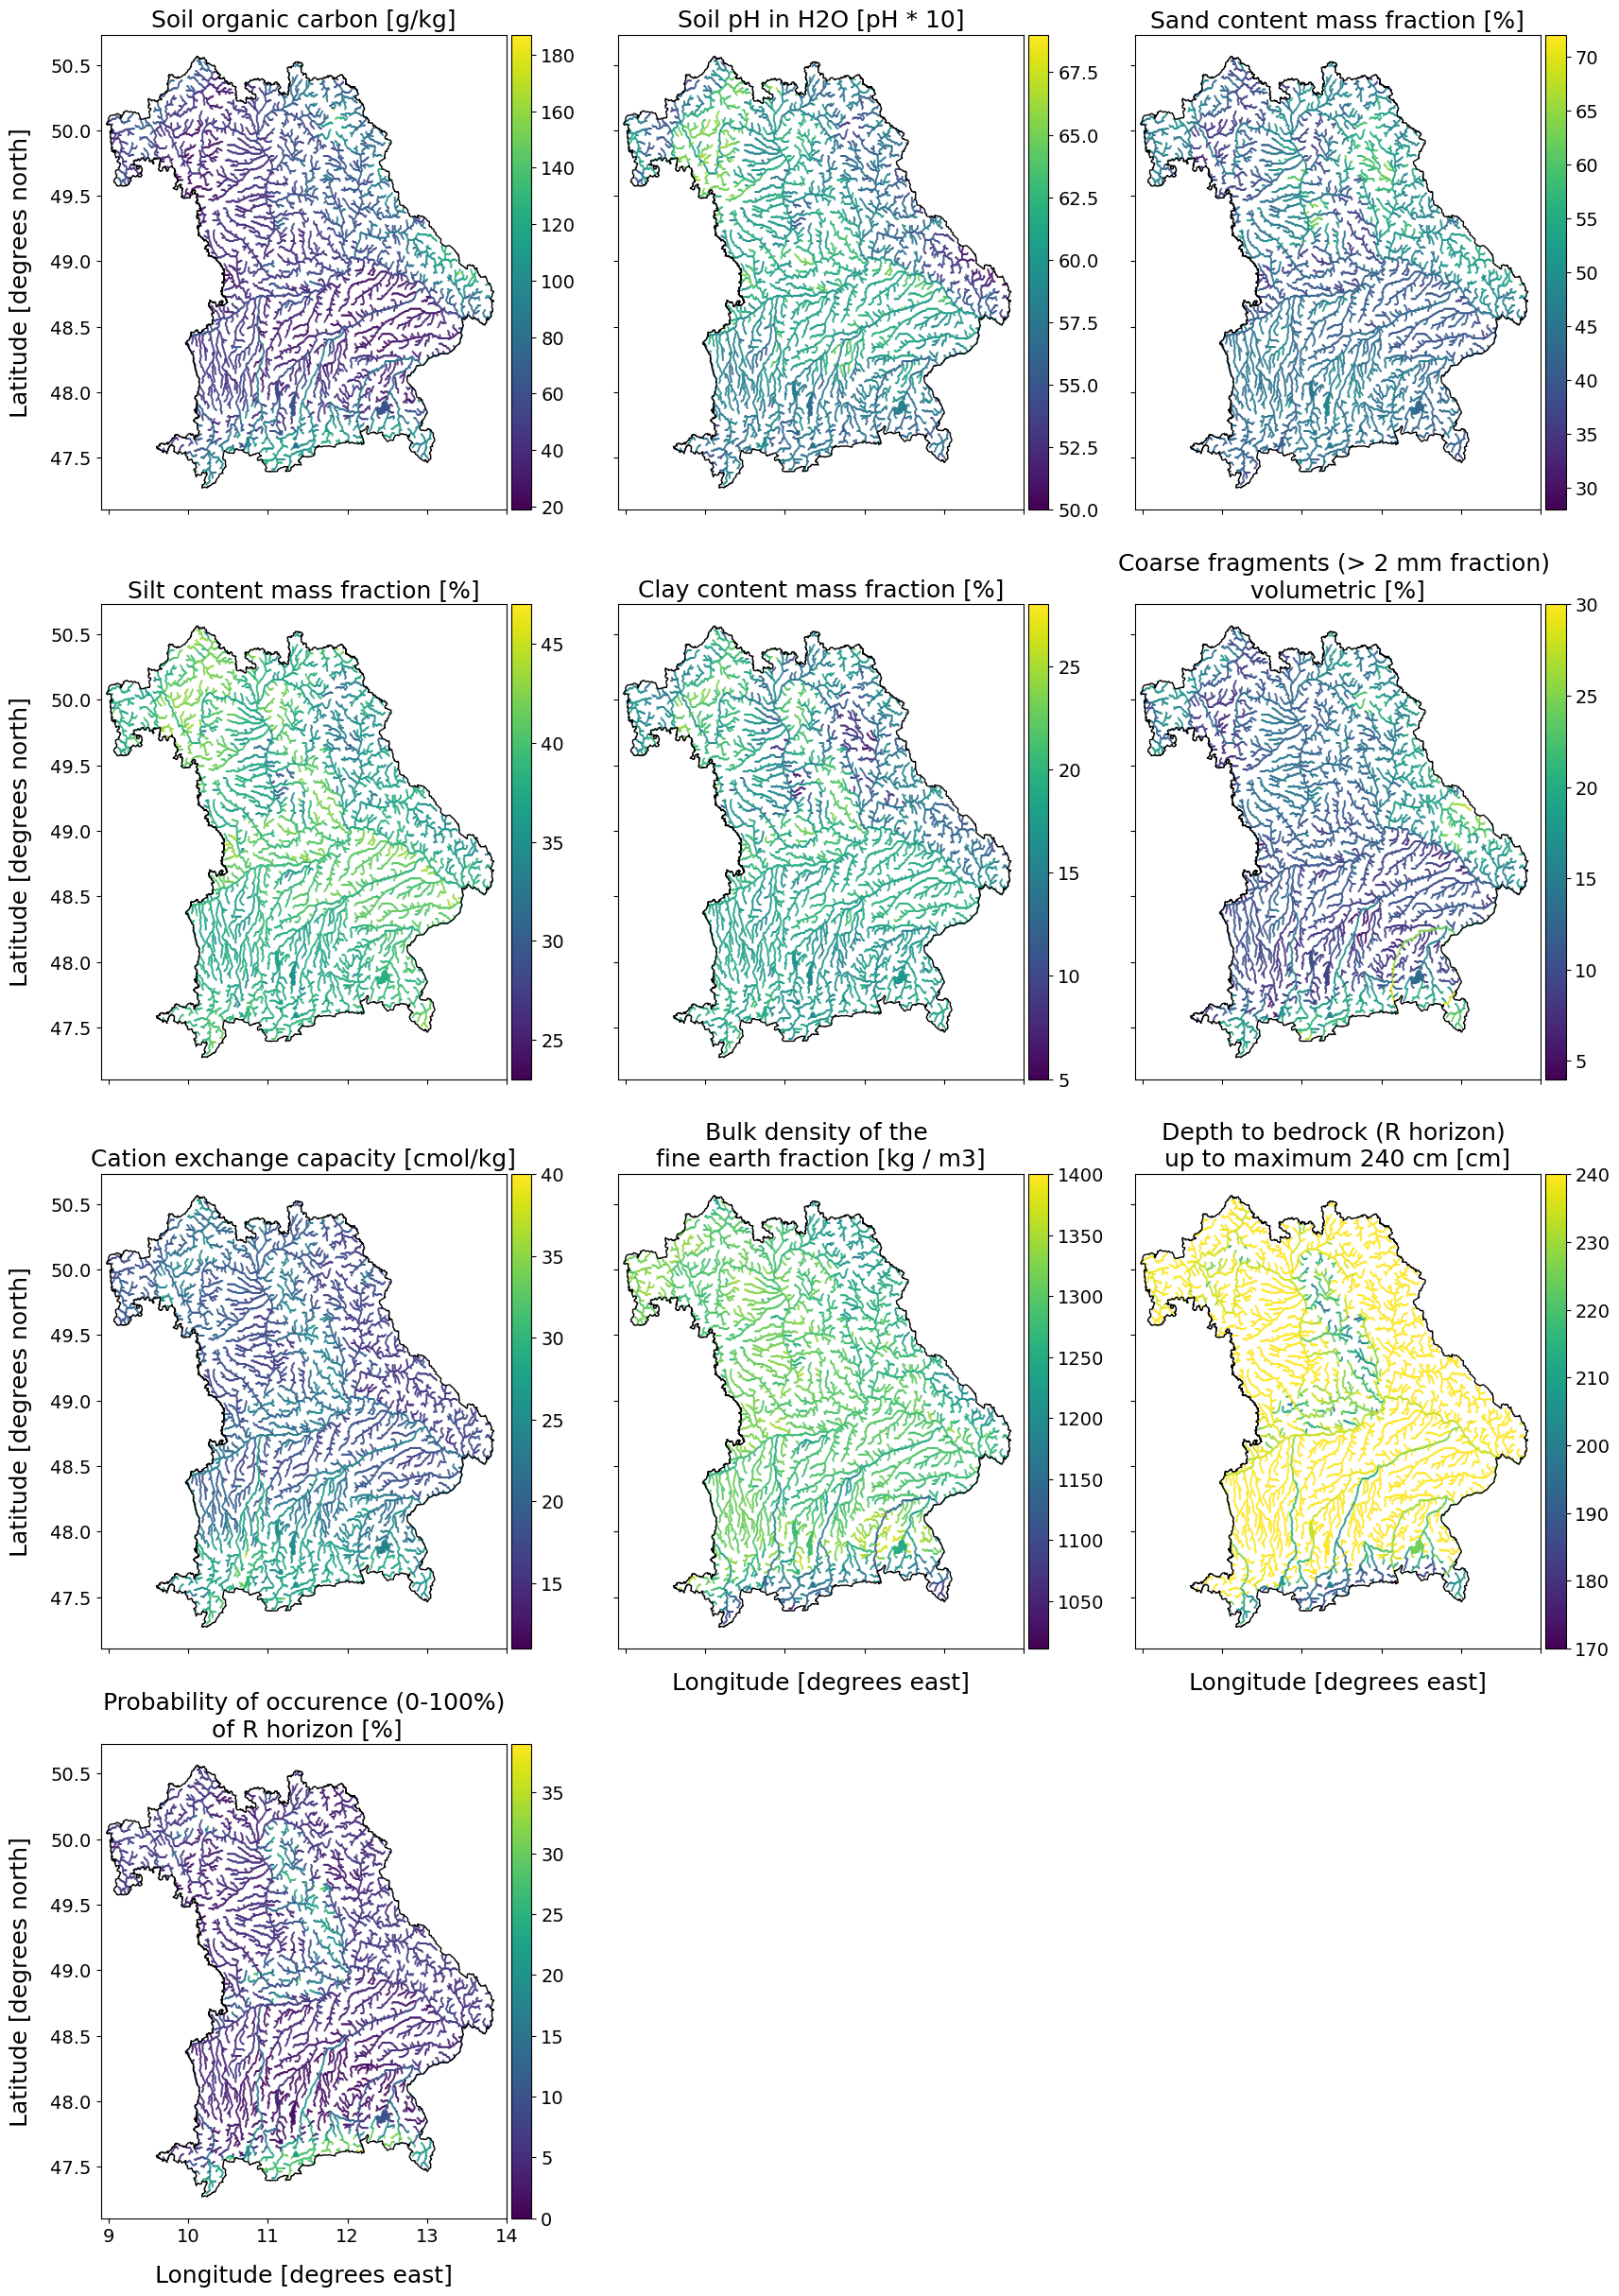

In [26]:
# Plot the clipped soil data

bands_dict = {0:'Soil organic carbon [g/kg]', 1:'Soil pH in H2O [pH * 10]', 2:'Sand content mass fraction [%]', 3:'Silt content mass fraction [%]', 4:'Clay content mass fraction [%]', 5:'Coarse fragments (> 2 mm fraction) \nvolumetric [%]', 6:'Cation exchange capacity [cmol/kg]', 7:'Bulk density of the \nfine earth fraction [kg / m3]', 8:'Depth to bedrock (R horizon) \nup to maximum 240 cm [cm]', 9:'Probability of occurence (0-100%)\n of R horizon [%]'}

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 30), sharex=True, sharey=True)

# flatten the 2D array of subplots for easy iteration
axes = axes.flatten()

for i in range(10):
    axes[i].plot(*bavaria_polygon.iloc[0,5].exterior.xy, color='black', linewidth=1)
    scatter = axes[i].scatter(df_filtered['lon'], df_filtered['lat'], c=df_filtered.iloc[:,i+3], cmap= 'viridis', s= 0.2 )
    axes[i].set_title(bands_dict[i], fontsize = 18)
    axes[i].set_xlim(8.9,14) 
    axes[i].tick_params(axis='x', labelsize=14)
    axes[i].tick_params(axis='y', labelsize=14)

    divider1 = make_axes_locatable(axes[i])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    cbar1 = plt.colorbar(scatter, cax=cax1)
    cbar1.ax.tick_params(labelsize=14)

    
    if i==7 or i == 8 or i==9:
        axes[i].set_xlabel('Longitude [degrees east]', fontsize = 18, labelpad = 14)
    if i in range(0,10,3):
        axes[i].set_ylabel('Latitude [degrees north]', fontsize = 18, labelpad = 14)
        
fig.delaxes(axes[11])
fig.delaxes(axes[10])
plt.savefig('stations_soil_average.jpg', format = 'jpg', bbox_inches = 'tight')

In [20]:
# save the filtered dataframe
filepath = "df_filtered_soil_avg"
with open(filepath, 'wb') as file:
    pickle.dump(df_filtered, file)